# SYDE 556/750 --- Assignment 1
**Student ID: 20814292**

*Note:* Please include your numerical student ID only, do *not* include your name.

*Note:* Refer to the [PDF](https://github.com/celiasmith/syde556-f22/raw/master/assignments/assignment_01/syde556_assignment_01.pdf) for the full instructions (including some hints), this notebook contains abbreviated instructions only. Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.

In [154]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

# Fix the numpy random seed for reproducible results
np.random.seed(42)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

# 1. Representation of Scalars

## 1.1 Basic encoding and decoding

**a) Computing gain and bias.** In general, for a neuron model $a = G[J]$ (and assuming that the inverse $J = G^{-1}[a]$ exists), solve the following system of equations to compute the gain $\alpha$, and the bias $J^\mathrm{bias}$ given a maximum rate $a^\mathrm{max}$ and an $x$-intercept $\xi$.

$$a^\mathrm{max} = G[\alpha + J^\mathrm{bias}] \,, \quad\quad 0 = G[\alpha \xi + J^\mathrm{bias}] \,.$$

Now, simplify these equations for the specific case $G[J] = \max(J, 0)$.

**b) Neuron tuning curves.** Plot the neuron tuning curves $a_i(x)$ for 16 randomly generated neurons following the intercept and maximum rate distributions described above.

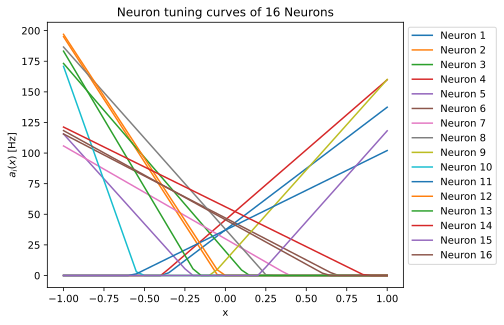

In [155]:
n = 16 # number of neurons
x_len = 41 # sample qty of x
delta_x = 0.05 # spacing between each sample of x

maximum_firing_rates = np.random.uniform(100, 200, size=(n, 1))
x_intercepts = np.random.uniform(-0.95, 0.95, size=(n, 1))
encoders = np.random.choice([1, -1], size=(n, 1))
x = np.linspace(-1, 1, num=x_len)

def G(J: np.ndarray):
    J[J < 0] = 0
    return J

alphas = maximum_firing_rates / (1.0 - x_intercepts)
j_bias = - (maximum_firing_rates * x_intercepts / (1.0 - x_intercepts))
A = G(alphas * encoders @ x.reshape(1, x_len) + j_bias)

for i in range(n):
    plt.plot(x, A[i, :], label=f'Neuron {i+1}')

plt.title(f"Neuron tuning curves of {n} Neurons")
plt.xlabel('x')
plt.ylabel('$a_{i}(x)$ [Hz]')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

**c) Computing identity decoders.** Compute the optimal identity decoder $\vec d$ for those 16 neurons (as shown in class). Report the value of the individual decoder coefficients. Compute $d$ using the matrix notation mentioned in the course notes. Do not apply any regularization. $A$ is the matrix of activities (the same data used to generate the plot in 1.1b).

In [156]:
D = np.array(np.linalg.lstsq(A.T, x, rcond=None)[0])

**d) Evaluating decoding errors.** Compute and plot $\hat{x}=\sum_i d_i a_i(x)$. Overlay on the plot the line $y=x$. Make a separate plot of $x-\hat{x}$ to see what the error looks like. Report the Root Mean Squared Error (RMSE) value.

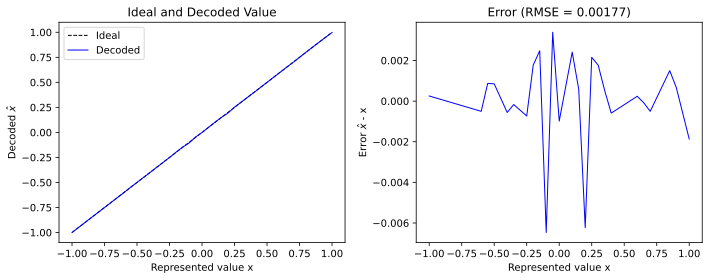

In [157]:
x_hat = A.T @ D

def rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted) ** 2))

identity_D_rmse = rmse(x, x_hat)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(x, x, label='Ideal', color='black', linestyle='--', linewidth=1)
plt.plot(x, x_hat, label='Decoded', color='blue', linewidth=1)
plt.title('Ideal and Decoded Value')
plt.xlabel('Represented value x')
plt.ylabel('Decoded $\hat{x}$')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, x_hat - x, color='blue', linewidth=1)
plt.title(f'Error (RMSE = {identity_D_rmse:.5f})')
plt.xlabel('Represented value x')
plt.ylabel('Error $\hat{x}$ - x')

plt.tight_layout()
plt.show()

**e) Decoding under noise.** Now try decoding under noise. Add random normally distributed noise to $a$ and decode again. The noise is a random variable with mean $\mu=0$ and standard deviation of $\sigma=0.2 \max(A)$ (where $\max(A)$ is the maximum firing rate of all the neurons). Resample this variable for every different $x$ value for every different neuron. Create all the same plots as in part d). Report the RMSE.

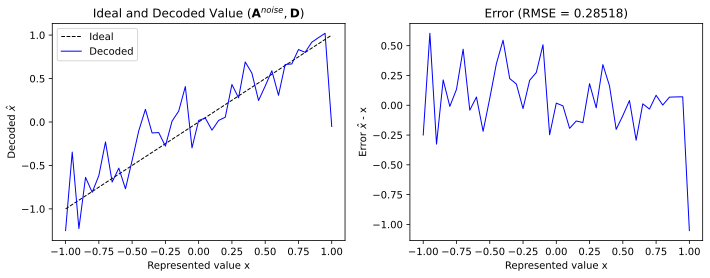

In [158]:
sigma = 0.2 * np.max(A)
noise = np.random.normal(0, sigma, size=A.shape)
noisy_A = A + noise

x_hat_noisy_A = noisy_A.T @ D
noisy_A_rmse = rmse(x, x_hat_noisy_A)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(x, x, label='Ideal', color='black', linestyle='--', linewidth=1)
plt.plot(x, x_hat_noisy_A, label='Decoded', color='blue', linewidth=1)
plt.title('Ideal and Decoded Value ($\mathbf{A}^{noise}, \mathbf{D}$)')
plt.xlabel('Represented value x')
plt.ylabel('Decoded $\hat{x}$')
plt.legend()

# Second subplot: Error
plt.subplot(1, 2, 2)
plt.plot(x, x_hat_noisy_A - x, color='blue', linewidth=1)
plt.title(f'Error (RMSE = {noisy_A_rmse:.5f})')
plt.xlabel('Represented value x')
plt.ylabel('Error $\hat{x}$ - x')

# Display the plots
plt.tight_layout()
plt.show()

**f) Accounting for decoder noise.** Recompute the decoder $\vec d$ taking noise into account (i.e., apply the appropriate regularization, as shown in class). Show how these decoders behave when decoding both with and without noise added to $a$ by making the same plots as in d) and e). Report the RMSE for all cases.

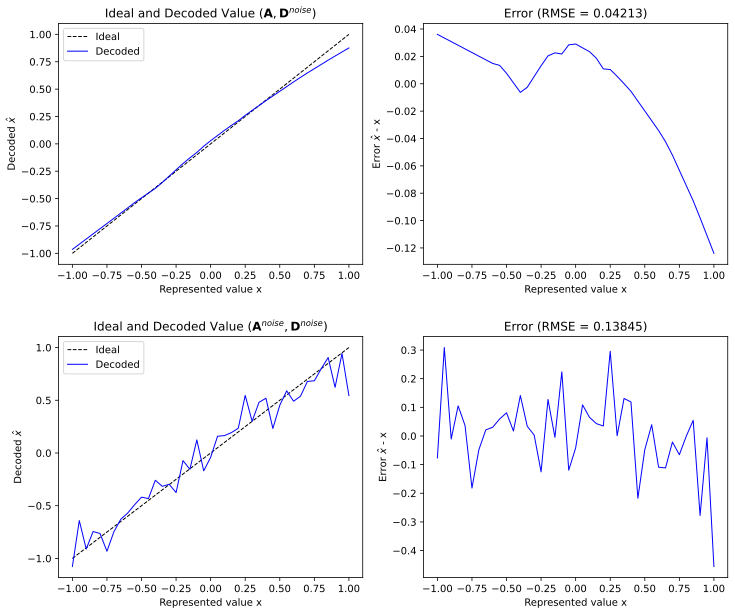

In [159]:
noisy_D = np.array(np.linalg.lstsq(A @ A.T + x_len * np.square(sigma) * np.eye(n), A @ x, rcond=None)[0])

x_hat_noisy_D = A.T @ noisy_D
x_hat_noisy_A_noisy_D = noisy_A.T @ noisy_D

noisy_D_rmse = rmse(x, x_hat_noisy_D)
noisy_A_noisy_D_rmse = rmse(x, x_hat_noisy_A_noisy_D)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.3)

# Top-left subplot: Ideal and Decoded Value (noisy_D)
axs[0, 0].plot(x, x, label='Ideal', color='black', linestyle='--', linewidth=1)
axs[0, 0].plot(x, x_hat_noisy_D, label='Decoded', color='blue', linewidth=1)
axs[0, 0].set_title('Ideal and Decoded Value ($\mathbf{A}, \mathbf{D}^{noise}$)')
axs[0, 0].set_xlabel('Represented value x')
axs[0, 0].set_ylabel('Decoded $\hat{x}$')
axs[0, 0].legend()

# Top-right subplot: Error (noisy_D)
axs[0, 1].plot(x, x_hat_noisy_D - x, color='blue', linewidth=1)
axs[0, 1].set_title(f'Error (RMSE = {noisy_D_rmse:.5f})')
axs[0, 1].set_xlabel('Represented value x')
axs[0, 1].set_ylabel('Error $\hat{x}$ - x')

# Bottom-left subplot: Ideal and Decoded Value (noisy_A + noisy_D)
axs[1, 0].plot(x, x, label='Ideal', color='black', linestyle='--', linewidth=1)
axs[1, 0].plot(x, x_hat_noisy_A_noisy_D, label='Decoded', color='blue', linewidth=1)
axs[1, 0].set_title('Ideal and Decoded Value ($\mathbf{A}^{noise}, \mathbf{D}^{noise}$)')
axs[1, 0].set_xlabel('Represented value x')
axs[1, 0].set_ylabel('Decoded $\hat{x}$')
axs[1, 0].legend()

# Bottom-right subplot: Error (noisy_A + noisy_D)
axs[1, 1].plot(x, x_hat_noisy_A_noisy_D - x, color='blue', linewidth=1)
axs[1, 1].set_title(f'Error (RMSE = {noisy_A_noisy_D_rmse:.5f})')
axs[1, 1].set_xlabel('Represented value x')
axs[1, 1].set_ylabel('Error $\hat{x}$ - x')

# Display the plots
plt.show()

**g) Interpretation.** Show a 2x2 table of the four RMSE values reported in parts d), e), and f). This should show the effects of adding noise and whether the decoders $d$ are computed taking noise into account. Write a few sentences commenting on what the table shows, i.e., what the effect of adding noise to the activities is with respect to the measured error and why accounting for noise when computing the decoders increases/decreases/does not change the measured RMSE.

In [160]:
headers = ['Decoder computed WITHOUT noise', 'Decoder computed WITH noise']
rmse_table = [[identity_D_rmse, noisy_D_rmse], [noisy_A_rmse, noisy_A_noisy_D_rmse]]
df = pd.DataFrame(rmse_table, columns=headers, index=['Noiseless A', 'Noisy A'])
print(df)

             Decoder computed WITHOUT noise  Decoder computed WITH noise
Noiseless A                        0.001770                     0.042130
Noisy A                            0.285178                     0.138454


The table shows that if a decoder is computed without noise, noise added to the activities would increase the measured error much more relative to if the decoder was initially computed with noise and noise was added to the activities later.

Mathematically, this can be described as:

rmse[0, 0] / rmse[1, 0] >> rmse[0, 1] / rmse[1, 1]

## 1.2 Exploring sources of error

**a) Exploring error due to distortion and noise.** Plot the error due to distortion $E_\mathrm{dist}$ and the error due to noise $E_\mathrm{noise}$ as a function of $n$, the number of neurons. Generate two different loglog plots (one for each type of error) with $n$ values of at least $[4, 8, 16, 32, 64, 128, 256, 512]$. For each $n$ value, do at least $5$ runs and average the results. For each run, different $\alpha$, $J^\mathrm{bias}$, and $e$ values should be generated for each neuron. Compute $d$ taking noise into account, with $\sigma = 0.1 \max(A)$. Show visually that the errors are proportional to $1/n$ or $1/n^2$.

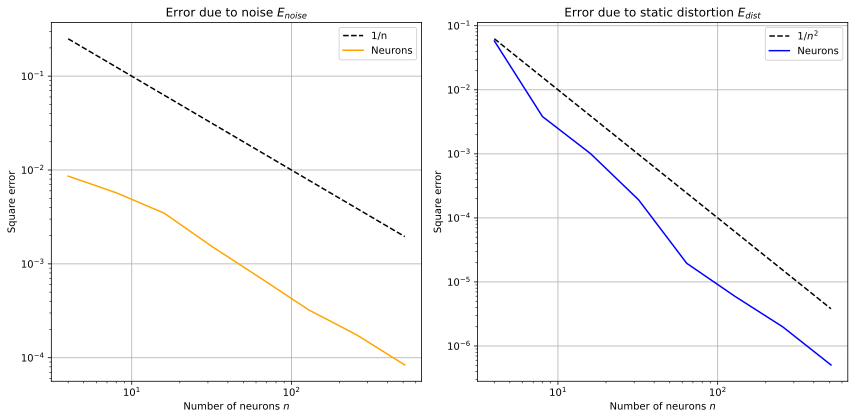

In [161]:
n_arr = np.array([2**i for i in range(2, 10)])
num_of_runs = 5

E_dist_avg_accumulator = []
E_noise_avg_accumulator = []

for curr_n in n_arr:
    E_dist_accumulator = []
    E_noise_accumulator = []

    for i in range(num_of_runs):
        maximum_firing_rates = np.random.uniform(100, 200, size=(curr_n, 1))
        x_intercepts = np.random.uniform(-0.95, 0.95, size=(curr_n, 1)) 
        encoders = np.random.choice([1, -1], size=(curr_n, 1))

        alphas = maximum_firing_rates / (1.0 - x_intercepts)
        j_bias = - (maximum_firing_rates * x_intercepts / (1.0 - x_intercepts))
        A = G(alphas * encoders @ x.reshape(1, x_len) + j_bias)

        sigma = 0.1*np.max(A)
        noisy_D = np.array(np.linalg.lstsq(A @ A.T + x_len * np.square(sigma) * np.eye(curr_n), A @ x, rcond=None)[0])
        E_dist = 0.5 * delta_x * np.sum(np.square(x - A.T @ noisy_D))
        E_noise = 0.5 * (sigma**2) * np.sum(np.square(noisy_D))

        E_dist_accumulator.append(E_dist)
        E_noise_accumulator.append(E_noise)
    
    E_dist_avg = sum(E_dist_accumulator) / num_of_runs
    E_noise_avg = sum(E_noise_accumulator) / num_of_runs
    E_dist_avg_accumulator.append(E_dist_avg)
    E_noise_avg_accumulator.append(E_noise_avg)

plt.figure(figsize=(12, 6))

# Plot E_noise_avg_accumulator
plt.subplot(1, 2, 1)
plt.loglog(n_arr, 1 / n_arr, label='1/n', color='black', linestyle='--')
plt.loglog(n_arr, E_noise_avg_accumulator, label='Neurons', color='orange')
plt.title('Error due to noise $\mathit{E}_{noise}$')
plt.xlabel('Number of neurons $\mathit{n}$')
plt.ylabel('Square error')
plt.grid(True)
plt.legend()

# Plot E_dist_avg_accumulator
plt.subplot(1, 2, 2)
plt.loglog(n_arr, 1 / np.square(n_arr), label='1/$n^2$', color='black', linestyle='--')
plt.loglog(n_arr, E_dist_avg_accumulator, label='Neurons', color='blue')
plt.title('Error due to static distortion $\mathit{E}_{dist}$')
plt.xlabel('Number of neurons $\mathit{n}$')
plt.ylabel('Square error')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


**b) Adapting the noise level.** Repeat part a) with $\sigma = 0.01 \max(A)$.

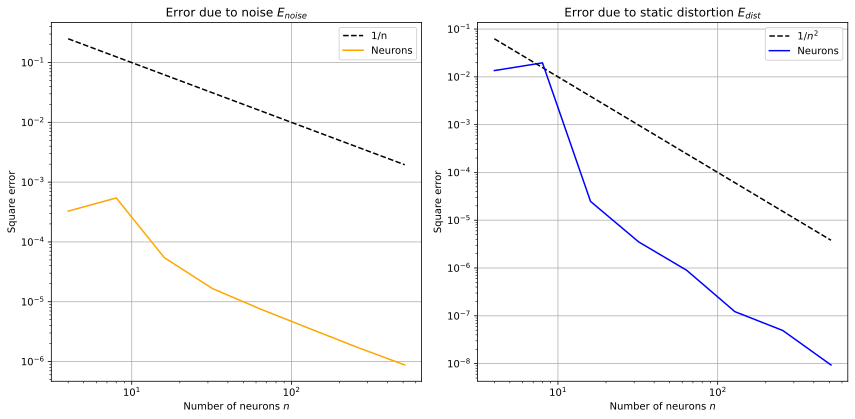

In [162]:
n_arr = np.array([2**i for i in range(2, 10)])
num_of_runs = 5

E_dist_avg_accumulator = []
E_noise_avg_accumulator = []

for curr_n in n_arr:
    E_dist_accumulator = []
    E_noise_accumulator = []

    for i in range(num_of_runs):
        maximum_firing_rates = np.random.uniform(100, 200, size=(curr_n, 1))
        x_intercepts = np.random.uniform(-0.95, 0.95, size=(curr_n, 1)) 
        encoders = np.random.choice([1, -1], size=(curr_n, 1))

        alphas = maximum_firing_rates / (1.0 - x_intercepts)
        j_bias = - (maximum_firing_rates * x_intercepts / (1.0 - x_intercepts))
        A = G(alphas * encoders @ x.reshape(1, x_len) + j_bias)

        sigma = 0.01 * np.max(A)
        noisy_D = np.array(np.linalg.lstsq(A @ A.T + x_len * np.square(sigma) * np.eye(curr_n), A @ x, rcond=None)[0])
        E_dist = 0.5 * delta_x * np.sum(np.square(x - A.T @ noisy_D))
        E_noise = 0.5 * (sigma**2) * np.sum(np.square(noisy_D))

        E_dist_accumulator.append(E_dist)
        E_noise_accumulator.append(E_noise)
    
    E_dist_avg = sum(E_dist_accumulator) / num_of_runs
    E_noise_avg = sum(E_noise_accumulator) / num_of_runs
    E_dist_avg_accumulator.append(E_dist_avg)
    E_noise_avg_accumulator.append(E_noise_avg)

plt.figure(figsize=(12, 6))

# Plot E_noise_avg_accumulator
plt.subplot(1, 2, 1)
plt.loglog(n_arr, 1 / n_arr, label='1/n', color='black', linestyle='--')
plt.loglog(n_arr, E_noise_avg_accumulator, label='Neurons', color='orange')
plt.title('Error due to noise $\mathit{E}_{noise}$')
plt.xlabel('Number of neurons $\mathit{n}$')
plt.ylabel('Square error')
plt.grid(True)
plt.legend()

# Plot E_dist_avg_accumulator
plt.subplot(1, 2, 2)
plt.loglog(n_arr, 1 / np.square(n_arr), label='1/$n^2$', color='black', linestyle='--')
plt.loglog(n_arr, E_dist_avg_accumulator, label='Neurons', color='blue')
plt.title('Error due to static distortion $\mathit{E}_{dist}$')
plt.xlabel('Number of neurons $\mathit{n}$')
plt.ylabel('Square error')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

**c) Interpretation.** What does the difference between the graphs in a) and b) tell us about the sources of error in neural populations?

It it evident that having a smaller amount of noise, characterized by a smaller $\sigma$, is beneficial for both sources of error, $\mathit{E}_{noise}$ and $\mathit{E}_{dist}$, across all values of $\mathit{n}$.

## 1.3 Leaky Integrate-and-Fire neurons

**a) Computing gain and bias.** As in the second part of 1.1a), given a maximum firing rate $a^\mathrm{max}$ and a bias $J^\mathrm{bias}$, write down the equations for computing $\alpha$ and the $J^\mathrm{bias}$ for this specific neuron model.

![title](assets/assignment_1/1.3a.png)

**b) Neuron tuning curves.** Generate the same plot as in 1.1b). Use $\tau_\mathrm{ref}=2 \mathrm{ms}$ and $\tau_{RC}=20 \mathrm{ms}$. Use the same distribution of $x$-intercepts and maximum firing rates as in 1.1.

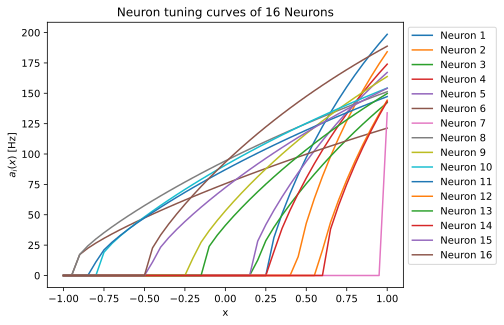

In [163]:
n = 16 # number of neurons
x_len = 41 # sample qty of x
delta_x = 0.05 # spacing between each sample of x
tau_ref = 2.0 / 1000.0 # given in ms, converting to s
tau_RC = 20.0 / 1000.0 # given in ms, converting to s
x = np.linspace(-1, 1, num=x_len)

maximum_firing_rates = np.random.uniform(100, 200, size=(n, 1))
x_intercepts = np.random.uniform(-1, 1, size=(n, 1))
encoders = np.random.choice([1, -1], size=(n, 1))
encoders = np.ones((n,1))

def G(J: np.ndarray):
    J[J > 1] = 1.0 / (tau_ref - tau_RC * np.log(1 - (1/J[J > 1])))
    J[J <= 1] = 0
    return J

alphas = (- 1.0 + (1.0 / (1.0 - np.exp((1.0 / tau_RC) * (tau_ref - (1.0 / maximum_firing_rates)))))) / (1.0 - x_intercepts)
j_bias = (1.0 - (x_intercepts / (1.0 - np.exp((1.0 / tau_RC) * (tau_ref - (1.0 / maximum_firing_rates)))))) / (1.0 - x_intercepts)
A = G(alphas * encoders @ x.reshape(1, x_len) + j_bias)

for i in range(n):
    plt.plot(x, A[i, :], label=f'Neuron {i+1}')

plt.title(f"Neuron tuning curves of {n} Neurons")
plt.xlabel('x')
plt.ylabel('$a_{i}(x)$ [Hz]')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

**c) Impact of noise.** Generate the same four plots as in 1.1f) (adding/not adding noise to $A$, accounting/not accounting for noise when computing $\vec d$), and report the RMSE both with and without noise.

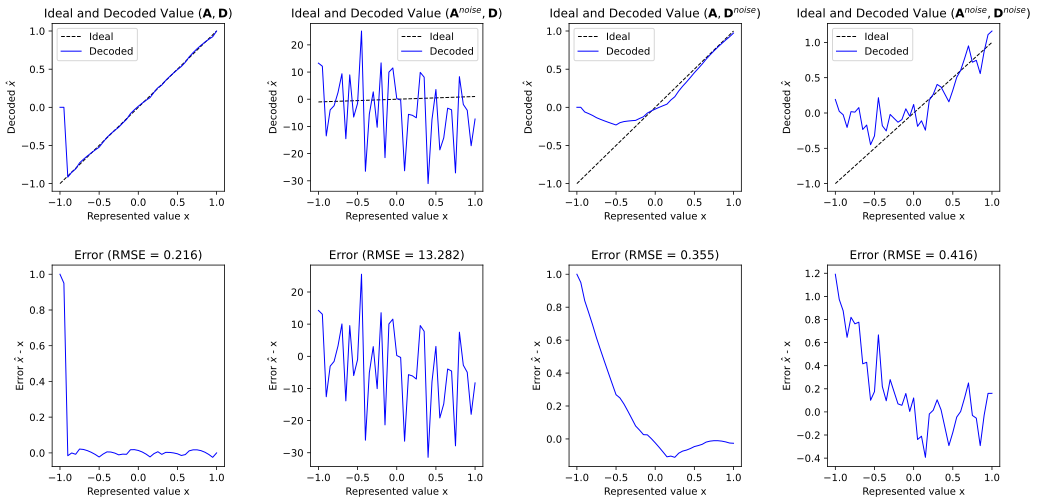

In [164]:
sigma = 0.2 * np.max(A)
noise = np.random.normal(0, sigma, size=A.shape)
noisy_A = A + noise

D = np.array(np.linalg.lstsq(A.T, x, rcond=None)[0])
noisy_D = np.array(np.linalg.lstsq(A @ A.T + x_len * np.square(sigma) * np.eye(n), A @ x, rcond=None)[0])

x_hat = A.T @ D 
x_hat_noisy_A = noisy_A.T @ D
x_hat_noisy_D = A.T @ noisy_D
x_hat_noisy_A_noisy_D = noisy_A.T @ noisy_D

RMSE = rmse(x.T, x_hat)
noisy_A_RMSE = rmse(x, x_hat_noisy_A)
noisy_D_RMSE = rmse(x, x_hat_noisy_D)
noisy_A_noisy_D_RMSE = rmse(x, x_hat_noisy_A_noisy_D)

fig, axs = plt.subplots(2, 4, figsize=(17, 8), gridspec_kw={'height_ratios': [1, 1.2]})
plt.subplots_adjust(hspace=0.4, wspace=0.5)

# A, D
axs[0, 0].plot(x, x, label='Ideal', color='black', linestyle='--', linewidth=1)
axs[0, 0].plot(x, x_hat, label='Decoded', color='blue', linewidth=1)
axs[0, 0].set_title('Ideal and Decoded Value ($\mathbf{A}, \mathbf{D}$)')
axs[0, 0].set_xlabel('Represented value x')
axs[0, 0].set_ylabel('Decoded $\hat{x}$')
axs[0, 0].legend()
axs[1, 0].plot(x, x_hat - x, color='blue', linewidth=1)
axs[1, 0].set_title(f'Error (RMSE = {RMSE:.3f})')
axs[1, 0].set_xlabel('Represented value x')
axs[1, 0].set_ylabel('Error $\hat{x}$ - x')

# noisy_A, D
axs[0, 1].plot(x, x, label='Ideal', color='black', linestyle='--', linewidth=1)
axs[0, 1].plot(x, x_hat_noisy_A, label='Decoded', color='blue', linewidth=1)
axs[0, 1].set_title('Ideal and Decoded Value ($\mathbf{A}^{noise}, \mathbf{D}$)')
axs[0, 1].set_xlabel('Represented value x')
axs[0, 1].set_ylabel('Decoded $\hat{x}$')
axs[0, 1].legend()
axs[1, 1].plot(x, x_hat_noisy_A - x, color='blue', linewidth=1)
axs[1, 1].set_title(f'Error (RMSE = {noisy_A_RMSE:.3f})')
axs[1, 1].set_xlabel('Represented value x')
axs[1, 1].set_ylabel('Error $\hat{x}$ - x')

# A, noisy_D
axs[0, 2].plot(x, x, label='Ideal', color='black', linestyle='--', linewidth=1)
axs[0, 2].plot(x, x_hat_noisy_D, label='Decoded', color='blue', linewidth=1)
axs[0, 2].set_title('Ideal and Decoded Value ($\mathbf{A}, \mathbf{D}^{noise}$)')
axs[0, 2].set_xlabel('Represented value x')
axs[0, 2].set_ylabel('Decoded $\hat{x}$')
axs[0, 2].legend()
axs[1, 2].plot(x, x_hat_noisy_D - x, color='blue', linewidth=1)
axs[1, 2].set_title(f'Error (RMSE = {noisy_D_RMSE:.3f})')
axs[1, 2].set_xlabel('Represented value x')
axs[1, 2].set_ylabel('Error $\hat{x}$ - x')

# noisy_A, noisy_D
axs[0, 3].plot(x, x, label='Ideal', color='black', linestyle='--', linewidth=1)
axs[0, 3].plot(x, x_hat_noisy_A_noisy_D, label='Decoded', color='blue', linewidth=1)
axs[0, 3].set_title('Ideal and Decoded Value ($\mathbf{A}^{noise}, \mathbf{D}^{noise}$)')
axs[0, 3].set_xlabel('Represented value x')
axs[0, 3].set_ylabel('Decoded $\hat{x}$')
axs[0, 3].legend()
axs[1, 3].plot(x, x_hat_noisy_A_noisy_D - x, color='blue', linewidth=1)
axs[1, 3].set_title(f'Error (RMSE = {noisy_A_noisy_D_RMSE:.3f})')
axs[1, 3].set_xlabel('Represented value x')
axs[1, 3].set_ylabel('Error $\hat{x}$ - x')
plt.show()

# 2. Reperesentation of Vectors

## 2.1 Vector tuning curves

**a) Plotting 2D tuning curves.** Plot the tuning curve of an LIF neuron whose 2D preferred direction vector is at an angle of $\theta=-\pi/4$, has an $x$-intercept at the origin $(0,0)$, and has a maximum firing rate of $100 \mathrm{Hz}$.

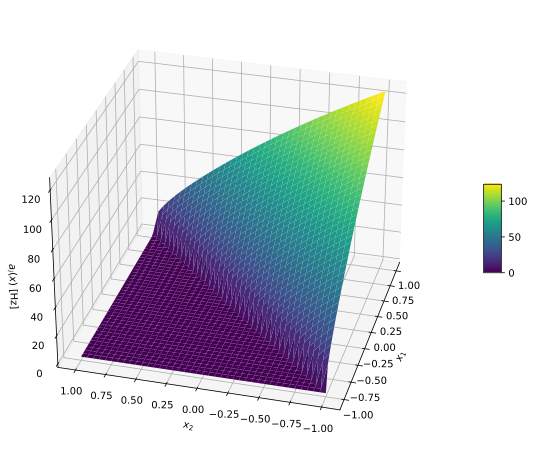

In [165]:
x_len = 41 # sample qty of x
delta_x = 0.05 # spacing between each sample of x
tau_ref = 2.0 / 1000.0 # given in ms, converting to s
tau_RC = 20.0 / 1000.0 # given in ms, converting to s

theta = -np.pi/4
maximum_firing_rates = np.array([[100]])
encoders = np.array([[np.cos(theta), np.sin(theta)]])
x_intercepts = np.array([[0,0]])
encoder_intercept_dot_product = np.sum(encoders * x_intercepts, axis=1)

x = np.linspace(-1, 1, num=x_len)
y = np.linspace(-1, 1, num=x_len)
xx, yy = np.meshgrid(x, y)
grid_coordinates = np.column_stack([xx.ravel(), yy.ravel()]).T

def G(J: np.ndarray):
    J[J > 1] = 1.0 / (tau_ref - tau_RC * np.log(1 - (1/J[J > 1])))
    J[J <= 1] = 0
    return J

alphas = (-1.0 + (1.0 / (1.0 - np.exp((1.0 / tau_RC) * (tau_ref - (1.0 / maximum_firing_rates)))))) / (1.0 - encoder_intercept_dot_product)
j_bias = (1.0 - (encoder_intercept_dot_product / (1.0 - np.exp((1.0 / tau_RC) * (tau_ref - (1.0 / maximum_firing_rates)))))) / (1.0 - encoder_intercept_dot_product)

A = G(alphas * encoders @ grid_coordinates + j_bias)
A = A.reshape(xx.shape) # Reshape A to 2d grid

# 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(xx, yy, A, cmap='viridis', edgecolor='none')
ax.view_init(azim=195)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$a_{i}(x)$ [Hz]')

# Show color bar for reference
fig.colorbar(surf, ax=ax, shrink=0.2, aspect=5)

plt.show()

**b) Plotting the 2D tuning curve along the unit circle.** Plot the tuning curve for the same neuron as in a), but only considering the points around the unit circle, i.e., sample the activation for different angles $\theta$. Fit a curve of the form $c_1 \cos(c_2\theta+c_3)+c_4$ to the tuning curve and plot it as well.

[56.09629209  1.15306087 -5.4080294  41.01987131]


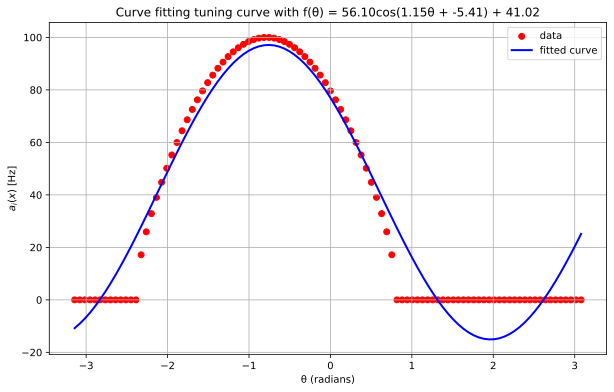

In [166]:
n_samples = 100  # Number of points to sample on the unit circle

angles = np.linspace(- np.pi, np.pi, num=n_samples, endpoint=False)

unit_circle_coordinates = np.vstack((np.cos(angles), np.sin(angles)))

A = G(alphas * encoders @ unit_circle_coordinates + j_bias)

def model_function(theta, c1, c2, c3, c4):
    return c1 * np.cos(c2 * theta + c3) + c4

# Initial guess for [c1, c2, c3, c4]
initial_guess = [1.0, 1.0, 1.0, 1.0]
params, params_covariance = curve_fit(model_function, angles, A.reshape(-1), p0=initial_guess)
print(params)
fitted_curve = model_function(angles, *params)

plt.figure(figsize=(10, 6))
plt.scatter(angles, A, label='data', color='red')
plt.plot(angles, fitted_curve, label='fitted curve', color='blue', linewidth=2)
plt.xlabel('θ (radians)')
plt.ylabel('$a_{i}(x)$ [Hz]')
plt.title(f'Curve fitting tuning curve with f(θ) = {params[0]:.2f}cos({params[1]:.2f}θ + {params[2]:.2f}) + {params[3]:.2f}')
plt.grid(True)
plt.legend()
plt.show()

**c) Discussion.** What makes a cosine a good choice for the curve fit in 2.1b? Why does it differ from the ideal curve?

A cosine is a good choice for the curve fit in 2.1b due to its parametization, as its parameters correlate well with the encoder preferred direction vector and the maximum firing rate. It differs from the ideal curve because of its smoothness, which makes its derivatives well-behaved along with a much more accurate reflection of the reality of biological systems.

## 2.2 Vector representation

**a) Choosing encoding vectors.** Generate a set of $100$ random unit vectors uniformly distributed around the unit circle. These will be the encoders $\vec e$ for $100$ neurons. Plot these vectors with a quiver or line plot (i.e., not just points, but lines/arrows to the points).

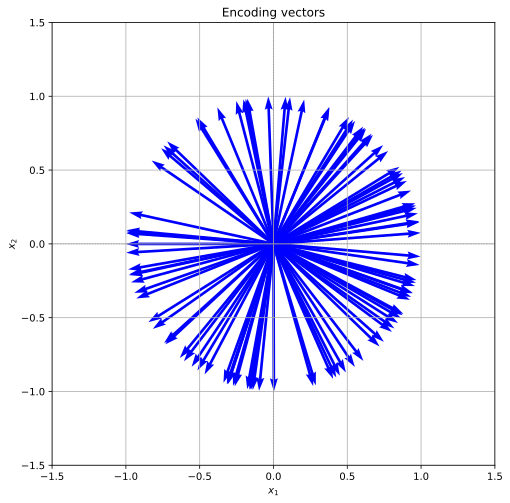

In [167]:
n_samples = 100  # Number of points to sample on the unit circle

angles = np.random.uniform(0, 2 * np.pi, size=(n_samples))

encoders = np.column_stack((np.cos(angles), np.sin(angles)))

plt.figure(figsize=(8, 8))
plt.quiver(np.zeros(n_samples), np.zeros(n_samples), encoders[:, 0], encoders[:, 1],
           angles='xy', scale_units='xy', scale=1, color='blue')

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.axhline(0, color='gray', lw=0.5, ls='--')
plt.axvline(0, color='gray', lw=0.5, ls='--')
plt.gca().set_aspect('equal', adjustable='box')


plt.title('Encoding vectors')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.grid()
plt.show()

**b) Computing the identity decoder.** Use LIF neurons with the same properties as in question 1.3. When computing the decoders, take into account noise with $\sigma = 0.2\max(A)$. Plot the decoders in the same way you plotted the encoders.

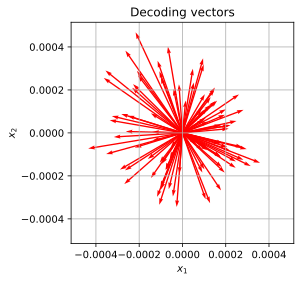

In [168]:
n = 100 # number of neurons
maximum_firing_rates = np.random.uniform(100, 200, size=(n, 1))
x_intercepts = np.random.uniform(-0.95, 0.95, size=(n, 2))
encoder_intercept_dot_product = np.array(np.sum(encoders * x_intercepts, axis=1)).reshape(n, 1)
alphas = (-1.0 + (1.0 / (1.0 - np.exp((1.0 / tau_RC) * (tau_ref - (1.0 / maximum_firing_rates)))))) / (1.0 - encoder_intercept_dot_product)
j_bias = (1.0 - (encoder_intercept_dot_product / (1.0 - np.exp((1.0 / tau_RC) * (tau_ref - (1.0 / maximum_firing_rates)))))) / (1.0 - encoder_intercept_dot_product)
A = G(alphas * encoders @ grid_coordinates + j_bias)

sigma = 0.2 * np.max(A)
noisy_D = np.array(np.linalg.lstsq(A @ A.T + (grid_coordinates.shape[1]) * np.square(sigma) * np.eye(n), A @ grid_coordinates.T, rcond=None)[0])

plt.figure(figsize=(4, 4))
plt.quiver(np.zeros(n), np.zeros(n), noisy_D[:, 0], noisy_D[:, 1], color='red', angles='xy', scale_units='xy', scale=1)

# Set axis limits based on the extents of noisy_D
max_extent = 1.1 * np.max(np.abs(noisy_D))  # 10% padding around max vector length
plt.xlim([-max_extent, max_extent])
plt.ylim([-max_extent, max_extent])

# Add labels and title
plt.title('Decoding vectors')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

# Show the plot
plt.grid()
plt.show()

**c) Discussion.** How do these decoding vectors compare to the encoding vectors?

The distribution of the decoding vectors seem to be fairly uniform, just like the encoding vectors. The magnitudes of the decoding vectors also seem to be fairly uniform, which is expected due to regularization. The magnitudes of the decoding vectors are mostly on the order of 10^-4, which makes sense because the magnitude of each decoder is uniform, there are n = 10^2 decoders, the maximum firing rate is on the order of 10^2, and the input space magnitude is on the order of 10^0. 

**d) Testing the decoder.** Generate 20 random $\vec x$ values throughout the unit circle (i.e.,~with different directions and radiuses). For each $\vec x$ value, determine the neural activity $a_i$ for each of the 100 neurons. Now decode these values (i.e. compute $\hat{x} = D \vec a$) using the decoders from part b). Plot the original and decoded values on the same graph in different colours, and compute the RMSE.

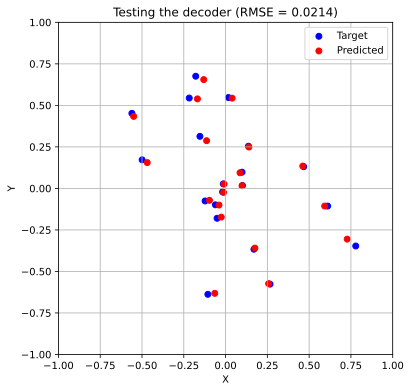

In [169]:
test_n = 20
angles = np.random.uniform(0, 2 * np.pi, size=(test_n))
radii = np.random.uniform(0, 1, size=(test_n))

test_input = np.array([radii * np.cos(angles), radii * np.sin(angles)])

A = G(alphas * encoders @ test_input + j_bias)

test_input_hat_with_decoder = (A.T @ noisy_D).T

plt.figure(figsize=(6, 6))
plt.scatter(test_input[0], test_input[1], c='blue', label='Target')
plt.scatter(test_input_hat_with_decoder[0], test_input_hat_with_decoder[1], c='red', label='Predicted')

plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Testing the decoder (RMSE = {rmse(test_input, test_input_hat_with_decoder):.4f})')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid(True)
plt.legend()
plt.show()

**e) Using encoders as decoders.** Repeat part d) but use the *encoders* as decoders. This is what Georgopoulos used in his original approach to decoding information from populations of neurons. Plot the decoded values and compute the RMSE. In addition, recompute the RMSE in both cases, but ignore the magnitude of the decoded vectors by normalizing before computing the RMSE.

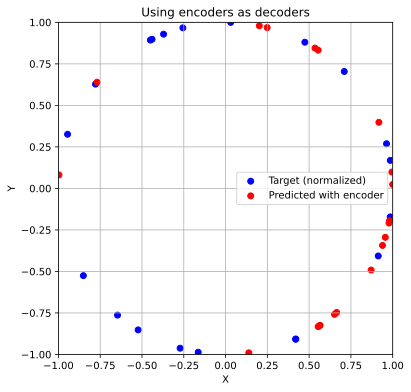

RMSE (target vs predicted with decoder): 0.06144413799442475
RMSE (target vs predicted with encoder): 0.5747742672334037


In [170]:
test_input_hat_with_encoder = (A.T @ encoders).T
test_input_hat_with_encoder_norm = np.linalg.norm(test_input_hat_with_encoder, axis=0)
test_input_hat_with_encoder = test_input_hat_with_encoder / test_input_hat_with_encoder_norm

test_input_norm = np.linalg.norm(test_input, axis=0)
test_input = test_input / test_input_norm

test_input_hat_with_decoder_norm = np.linalg.norm(test_input_hat_with_decoder, axis=0)
test_input_hat_with_decoder = test_input_hat_with_decoder / test_input_hat_with_decoder_norm

plt.figure(figsize=(6, 6))
plt.scatter(test_input[0], test_input[1], c='blue', label='Target (normalized)')
plt.scatter(test_input_hat_with_encoder[0], test_input_hat_with_encoder[1], c='red', label='Predicted with encoder')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Using encoders as decoders')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid(True)
plt.legend()
plt.show()

print(f"RMSE (target vs predicted with decoder): {rmse(test_input, test_input_hat_with_decoder)}")
print(f"RMSE (target vs predicted with encoder): {rmse(test_input, test_input_hat_with_encoder)}")


**f) Discussion.** When computing the RMSE on the normalized vectors, using the encoders as decoders should result in a larger, yet still surprisingly small error. Thinking about random unit vectors in high dimensional spaces, why is this the case? What are the relative merits of these two approaches to decoding?

With random unit vectors in high dimensional spaces, it is much more probable for the vectors to be orthogonal, and less correlated (large dot product). This allows for a much more accurate decoding, especially across a uniform space. Using the decoder to decode will yield much more accurate results, but it requires more computation (especially with solving the least squares problem). Using the encoder to decode with yield less accurate results, but this trade off can be made up for with less computation requirements, which means more potential for real-time applications. Additionally, if the error in magnitude of the predicted versus the actual is not fairly important, then using the encoder as a decoder can yield adequate results.